In [1]:
import pandas as pd

In [2]:
#df_econ=pd.read_excel("economic_news_test.xlsx")
df_econ=pd.read_excel("us_economic_news_b.xlsx")

In [4]:
# Source link for data set is at https://data.world/crowdflower/economic-news-article-tone 
df_relevant=df_econ[df_econ["relevance"]=="yes"]

In [5]:
df_relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2901 entries, 1 to 5014
Data columns (total 19 columns):
_unit_id                 2901 non-null int64
_golden                  2901 non-null bool
_unit_state              2901 non-null object
_trusted_judgments       2901 non-null int64
_last_judgment_at        2873 non-null datetime64[ns]
positivity               2899 non-null float64
positivity:confidence    2901 non-null float64
relevance                2901 non-null object
relevance:confidence     2901 non-null float64
orig__golden             11 non-null float64
articleid                2901 non-null int64
date                     2901 non-null datetime64[ns]
headline                 2901 non-null object
lineid                   2901 non-null object
next_sentence            2901 non-null object
positivity_gold          35 non-null object
previous_sentence        2260 non-null object
relevance_gold           35 non-null object
text                     2901 non-null object
dtypes: bo

In [8]:

from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


In [7]:
import tensorflow as tf

In [9]:
import numpy as np

In [10]:
df_relevant['score']=df_relevant['positivity'].map(lambda x: 1 if x > 4 else 0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
### Import additional Keras modules for NLP
import keras

In [12]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [13]:

# output directory name:
output_dir = 'model_output/'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # new!

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

In [14]:
## Tokenizer for text data is set to a maximum word length for sentiment
tokenizer = Tokenizer(num_words=max_review_length)



In [15]:
#### Select dataframe for sentiment tokenization
sent_text=df_relevant['text']

In [64]:
pd.set_option('display.max_colwidth',-1)

In [65]:
sent_text.head()

1    The Nasdaq composite index, home of technology companies large and small, fell 1.7 percent even as the Dow Jones industrial average rose 20.81 points, to 3,342.99.                                                                                                                                                                                                                                                                                                                                       
2    The bond market continued to rally, propelling (he normally placid ,' Dow Jones utility average to a gain of 6.01\tpoints, or 2.5,6 percent, to 240.61   the best one-day.advance, in percentage terms, in nearly five years. The yield on the 30-year Treasury bond fell to another record low. (Page  ¢ D18.J                                                                                                                                                                                           
3    The

In [16]:
#Fit on the text number of words
X_vec=tokenizer.fit_on_texts(sent_text)

In [17]:
#Word Vector for text
X_seq=tokenizer.texts_to_sequences(sent_text)

In [19]:
#print(tokenizer.word_index)
word_index=tokenizer.word_index

In [18]:
# Select the sentiment class based on the positivity as the target
y=np.array(df_relevant['score'])

In [19]:
import sklearn.cross_validation as cv

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
#### Perform the train test split for the model
X_train,X_test,y_train,y_test=cv.train_test_split(X_seq,y,test_size=1.0/3,random_state=0)

In [21]:
#### Import libraries for CNN
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 
from keras.callbacks import ModelCheckpoint

In [22]:
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

In [23]:
x_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_test = pad_sequences(X_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [24]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [28]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])

Train on 1934 samples, validate on 967 samples
Epoch 1/4
1934/1934 [==============================] - 28s - loss: 0.6816 - acc: 0.5781 - val_loss: 0.6866 - val_acc: 0.5595
Epoch 2/4
1934/1934 [==============================] - 28s - loss: 0.6792 - acc: 0.5791 - val_loss: 0.6856 - val_acc: 0.5595
Epoch 3/4
1934/1934 [==============================] - 28s - loss: 0.6743 - acc: 0.5791 - val_loss: 0.6844 - val_acc: 0.5595
Epoch 4/4
1934/1934 [==============================] - 28s - loss: 0.6674 - acc: 0.5791 - val_loss: 0.6835 - val_acc: 0.5605


In [29]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [30]:

y_hat = model.predict_proba(x_test)

960/967 [============================>.] - ETA: 0s

In [31]:
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

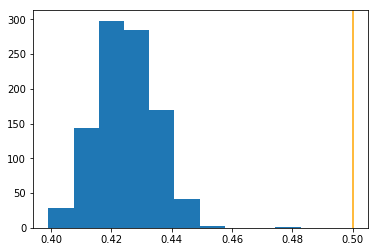

In [32]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [33]:
"{:0.2f}".format(roc_auc_score(y_test, y_hat)*100.0)

'53.66'

In [34]:
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense

In [35]:
model_3 = Sequential()
model_3.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model_3.add(SpatialDropout1D(drop_embed))
#model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))

model_3.add(Convolution1D(64, 3, padding='same'))
model_3.add(Convolution1D(32, 3, padding='same'))
model_3.add(Convolution1D(16, 3, padding='same'))
model_3.add(Flatten())

model_3.add(Dropout(0.2))
model_3.add(Dense(180,activation='sigmoid'))

#model.add(GlobalMaxPooling1D())
#model.add(Dense(n_dense, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(1, activation='sigmoid'))

In [66]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 64)           12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 32)           6176      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 400, 16)           1552      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6400)              0         
__________

In [36]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
epochs=4

In [38]:
model_3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])

Train on 1934 samples, validate on 967 samples
Epoch 1/4
1934/1934 [==============================] - 9s - loss: 0.7036 - acc: 0.5502 - val_loss: 0.7149 - val_acc: 0.5595
Epoch 2/4
1934/1934 [==============================] - 8s - loss: 0.6943 - acc: 0.5538 - val_loss: 0.6867 - val_acc: 0.5595
Epoch 3/4
1934/1934 [==============================] - 8s - loss: 0.6732 - acc: 0.5900 - val_loss: 0.6984 - val_acc: 0.5595
Epoch 4/4
1934/1934 [==============================] - 8s - loss: 0.6343 - acc: 0.6355 - val_loss: 0.7009 - val_acc: 0.5346


In [39]:
model_3.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [40]:
y_hat_3 = model_3.predict_proba(x_test)

928/967 [===========================>..] - ETA: 0s

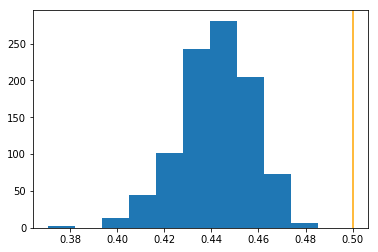

In [41]:
plt.hist(y_hat_3)
_ = plt.axvline(x=0.5, color='orange')

In [42]:
"{:0.2f}".format(roc_auc_score(y_test, y_hat_3)*100.0)

'50.10'

In [52]:
#### The accuracy seems poor but test it with a sample of retweets
tweet=["Bitcoin news: Bank of America CEO reveals HUGE investment in blockchain technology",
      "Report Claims 34,000 Ethereum Smart Contracts Are Vulnerable to Bugs",
      "Bitcoin Price Dips Below $11,000 as Market Endures Correction",
      "Bitcoin up 100% in under 2 months. Shanghai down almost 10% same timeframe, compared to most global stocks up. Probably",
      "Georgia Becomes Latest State to Consider Bitcoin for Tax Payments"]


In [53]:
#Fit on the text number of words
tweet_vec=tokenizer.fit_on_texts(tweet)

In [54]:
#Word Vector for text
tweet_seq=tokenizer.texts_to_sequences(tweet)

In [55]:
print (tweet_seq)

[[218, 91, 2, 222, 3], [137, 29, 24, 4], [86, 373, 211, 29, 15, 20], [58, 3, 319, 67, 98, 93, 242, 126, 328, 4, 79, 107, 58], [323, 4, 8, 122]]


In [56]:
tweet_test = pad_sequences(tweet_seq, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [60]:
tweet_hat=model_3.predict_proba(tweet_test)

5/5 [==============================] - 0s


In [61]:
tweet_hat

array([[ 0.45119536],
       [ 0.45453036],
       [ 0.44329631],
       [ 0.44442919],
       [ 0.44244385]], dtype=float32)

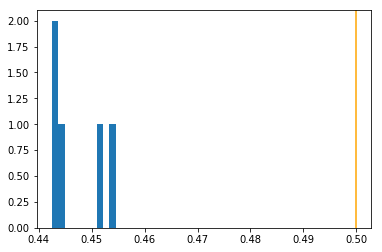

In [59]:
plt.hist(tweet_hat)
_ = plt.axvline(x=0.5, color='orange')

In [62]:
tweet_hat_old = model.predict_proba(tweet_test)

5/5 [==============================] - 0s


In [63]:
tweet_hat_old

array([[ 0.46297097],
       [ 0.46093705],
       [ 0.45622265],
       [ 0.44236729],
       [ 0.46097776]], dtype=float32)